# Using Normalizing Flows to optimize mixture of Gaussians

This notebook contains short experiment which shows how to use Maximum Likelihood estimation together with Normalizing Flows and Mixture of Gaussians. Here I solve very simple problem. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors

%matplotlib inline

In [2]:
tf.reset_default_graph()

## Create a toy model 
A toy model is a mixture of two gaussians. In the next steps we will try to recover its parameters with MLE method.

In [2]:
batch_size=512
mix = 0.4

x_dist = tfd.Mixture(
    cat = tfd.Categorical(probs=[mix, 1.-mix]),
    components = [
        tfd.MultivariateNormalDiag(loc=[-4., 0.0], scale_diag=[1., 2.0]),
        tfd.MultivariateNormalDiag(loc=[3., 0.0], scale_diag=[0.5, 0.5])
    ]
)
x_samples = x_dist.sample(batch_size)

Show samples from the model

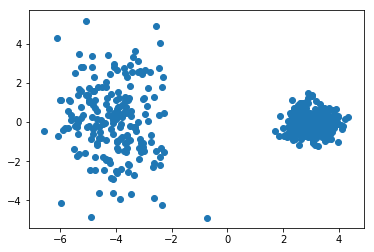

In [3]:
with tf.Session() as sess:
    x_samples_np = sess.run(x_samples)
    
plt.scatter(*x_samples_np.T)

## Create model with trainable parameters

In [4]:
probs = tf.get_variable('mixture_probs', [2], dtype=tf.float32)
# keep probs normalized
probs = tf.nn.softmax(probs)

scale_fn = lambda name: tf.nn.softplus(tf.get_variable(name, initializer=np.ones([2], dtype='float32')))

model_dist = tfd.Mixture(
    cat = tfd.Categorical(probs=probs),
    components = [
        tfd.MultivariateNormalDiag(
            loc=tf.get_variable('loc1', [2]), 
            scale_diag=scale_fn('scale1')
        ),
        tfd.MultivariateNormalDiag(
            loc=tf.get_variable('loc2', [2]), 
            scale_diag=scale_fn('scale2')
        )
    ]
)

## Define loss function
$$L = -\frac{1}{N_B}\sum_k log(p(x))$$

In [6]:
loss = - tf.reduce_mean(model_dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train model

In [8]:
model_samples = model_dist.sample(512)

0 6.730281


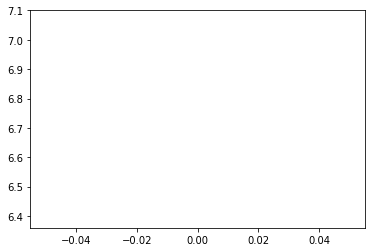

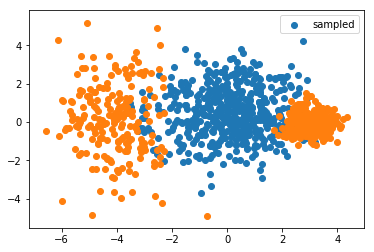

1000 4.5832253


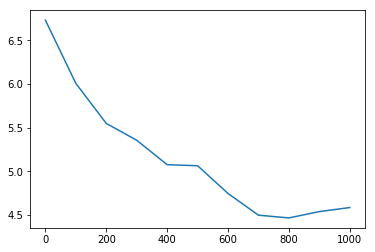

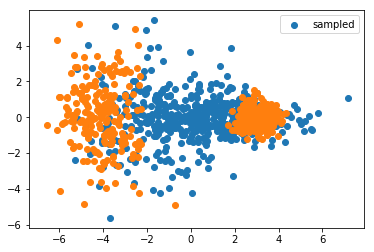

2000 3.8633533


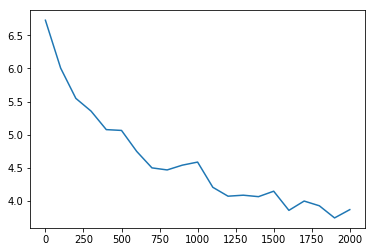

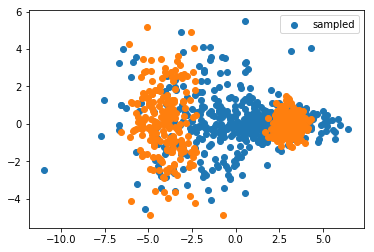

3000 3.412714


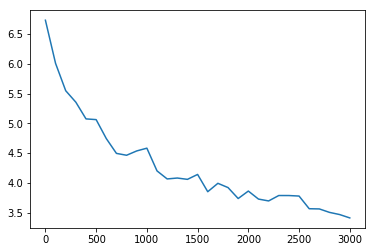

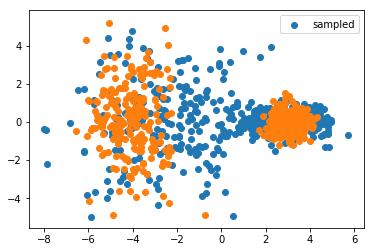

4000 3.17698


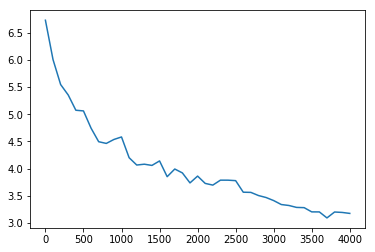

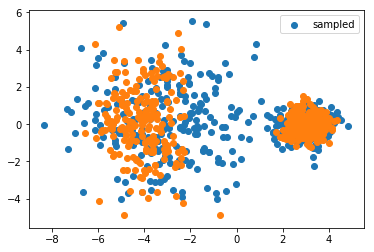

5000 3.1288545


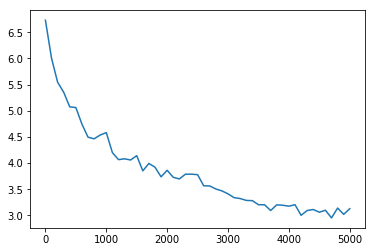

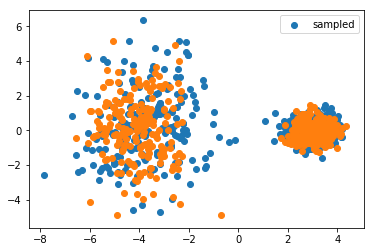

6000 2.9526136


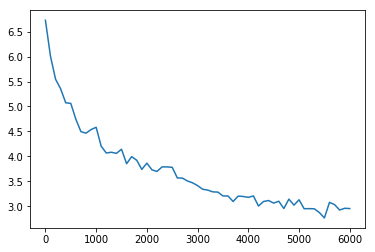

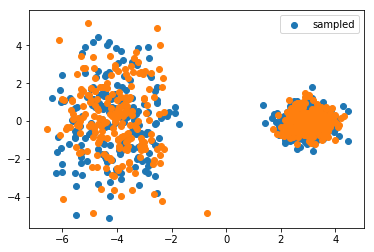

7000 2.8726099


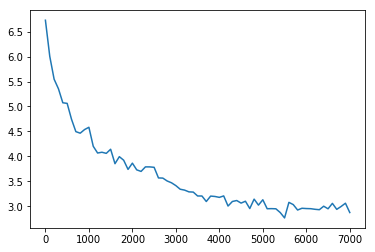

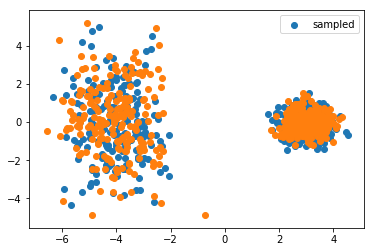

8000 3.0044491


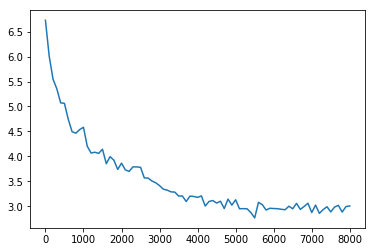

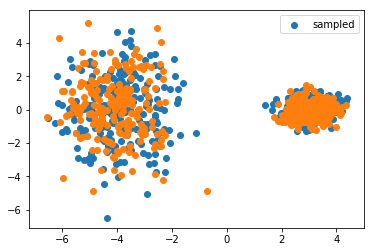

9000 2.8461075


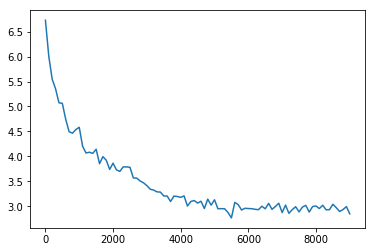

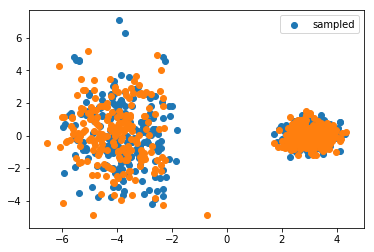

In [9]:
NUM_STEPS = int(1e4)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 100 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e3) == 0:
        print(i, np_loss)
        plt.plot(global_step, np_losses)
        plt.show()
        
        y_samples_np = sess.run(model_samples) 
        
        plt.scatter(*y_samples_np.T, label='sampled')
        plt.scatter(*x_samples_np.T)
        plt.legend()
        plt.show()

## Plot learned distribution

In [10]:
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
points = np.vstack([X, Y]).reshape([2, -1]).T.astype(np.float32)

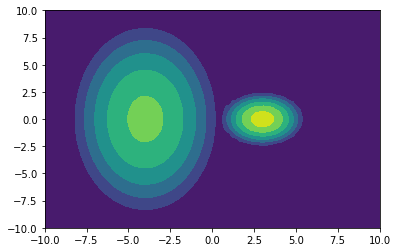

In [11]:
points_probs_np = sess.run(model_dist.prob(points))
plt.tricontourf(points[:, 0], points[:, 1], np.log(points_probs_np + 1e-6))